<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [40]:
%%capture
pip install pyswarms

In [41]:
%%capture
pip install scipy

In [42]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pyswarms as ps

In [43]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [44]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [45]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [46]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 17000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = 'pso'

# Configuraçaõ dos cerarios utulidados para os testes: primeiro_cenario, segundo_cenario, terceiro_cenario, quarto_cenario
CENARIO = 'primeiro_cenario'

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/Resultados_{CENARIO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_{CENARIO}'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'
NOME_ARQUIVO_PARAMETROS = 'parametros'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO_TESTE = f'{CENARIO}'

In [49]:
print(LINK_ARQUIVO_PRINCIPAL)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_primeiro_cenario/


In [50]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [51]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [52]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [53]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [54]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [55]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [56]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [57]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.2: 2000, 0.4: 4000, 0.5: 9000, 0.9: 12000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.1 or si > 1.0 else np.interp(si, [0.2, 0.4, 0.5, 0.9], [2000, 4000, 9000, 12000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [58]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/{CENARIO_TESTE}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [59]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [60]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return (-1)*fitness

In [61]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 3, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2024-06-28 22:49:17,084 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-1.28e-23
2024-06-28 22:49:17,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.2810802563172146e-23, best pos: [148.21179584   2.99425777   0.63116975]


In [62]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.21179584213087
beta: 2.9942577674688264
theta: 0.6311697487875223

Tempo de Convergência para a primeira etapa: 0.02938055992126465 segundos


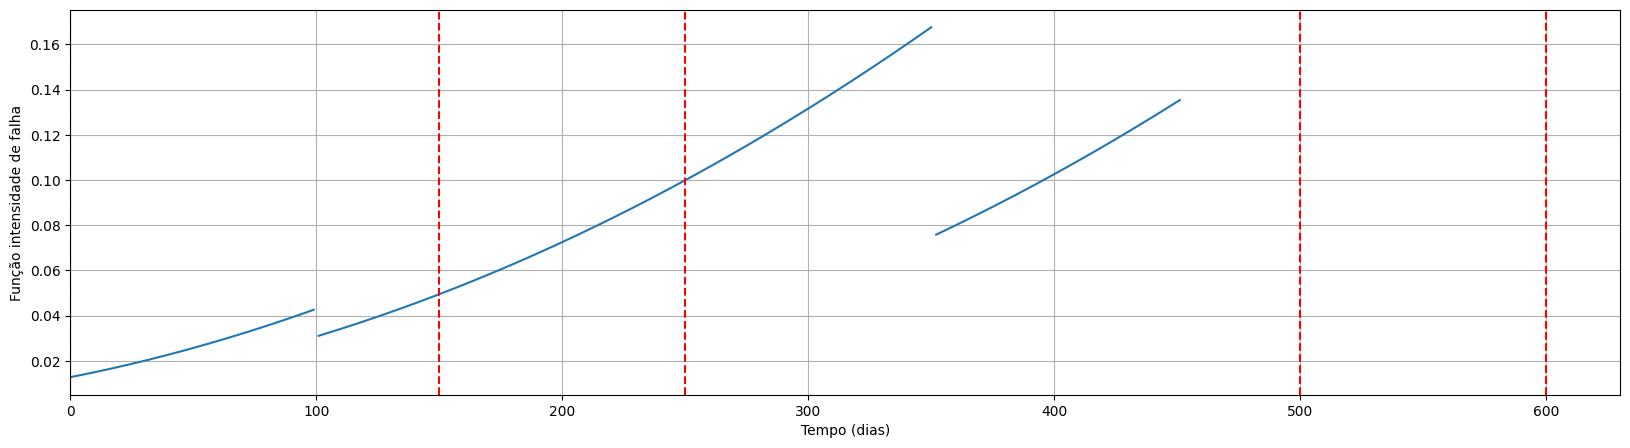

Fator ajuste:  [0.21460965150428413, 0.26063829953822626, 0.4193124564099424, 0.1137774836443638]


In [63]:
lamb = 148.0738165527265
beta = 2.9738148965776925
theta = 0.603936063904796

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [64]:
# Nome do arquivo CSV para salvar os resultados dos parametros
nome_arquivo_parametros = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PARAMETROS}.csv'

In [65]:
# # Gravar os valores de Lambda, Beta e Theta em um arquivo separado
# melhores_parametros = []

# try:
#     with open(nome_arquivo_parametros, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_parametros.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução


# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_parametros), lamb, beta, theta, convergence_time_first_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo_parametros, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [66]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo_parametros, sep=",")
resultado.head(10)

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
0,0,148.782148,2.998684,0.637038,0.010831
1,1,149.042532,2.992778,0.656598,0.017805
2,2,148.386605,2.983588,0.623777,0.010281
3,3,147.229446,2.984549,0.644768,0.006866
4,4,147.426312,2.999010,0.719508,0.006670
5,5,148.643976,2.997044,0.664144,0.006516
6,6,148.117912,2.985416,0.656295,0.014861
7,7,149.561411,2.999016,0.574874,0.010471
8,8,149.752366,2.963397,0.577784,0.016125
9,9,149.545681,2.986967,0.592344,0.009183


In [67]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
count,11.000000,11.000000,11.000000,11.000000,11.000000
mean,5.000000,148.652251,2.989873,0.640842,0.010613
std,3.316625,0.829991,0.010818,0.046879,0.004010
min,0.000000,147.229446,2.963397,0.574874,0.006516
25%,2.500000,148.252258,2.984982,0.608061,0.007000
50%,5.000000,148.686377,2.992778,0.644768,0.010281
75%,7.500000,149.294107,2.998419,0.660371,0.012846
max,10.000000,149.752366,2.999016,0.719508,0.017805


In [68]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']

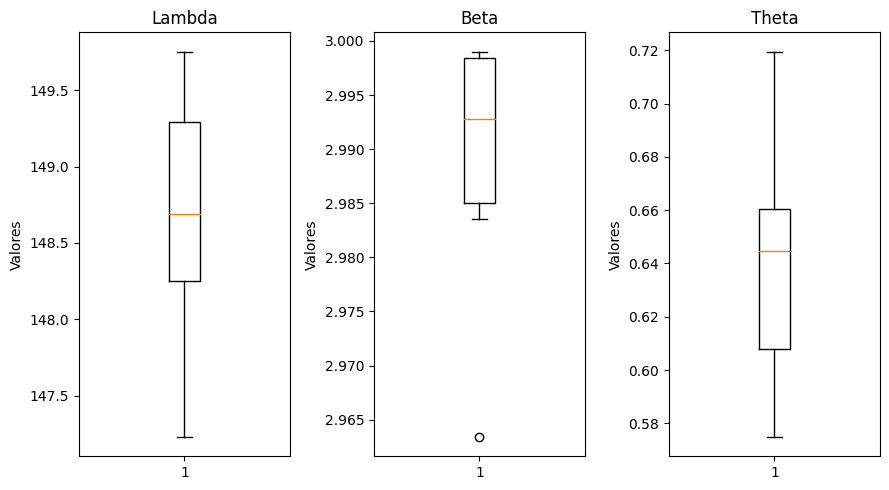

In [69]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [70]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [71]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.2, 3:0.4, 5:0.5, 7:0.9}

    results = [] # Lista para armazenar os resultados das funções objetivo

    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [72]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
max_bound = np.array([1.3] * dimensions)  # Limite superior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

2024-06-28 22:49:21,006 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  10%|█         |10/100, best_cost=2.87e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 38, 276, 307, 420, 451, 605]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.017513920741705442, 6.084107988838591, 7.979069134877532, 19.02608441603365, 23.190352134463005, 54.53655431118651, 53.27528044005426]
Custo =  11445.341098002798


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 3, 92, 151, 180, 211, 246, 457, 517]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 9.21021316427903e-06, 0.24018468628548043, 0.9266

pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=1.73e+3



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 396]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 18.64077771572166, 56.47485921335325]
Custo =  3502.8622487873827


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 1, 181]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 3.5107458165773186e-07, 1.813449576378241, 58.35446556867383]
Custo =  4191.151799667275


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 183, 394]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 1.8771982489492782, 16.190898481164346, 54.28152472256182]
Custo =  3975.135998833496


Número de ciclos de manutenção: 2 5
Tempos para manute

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=1.73e+3



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 367]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 14.423314393055277, 55.796332052907474]
Custo =  3391.1464320531963


Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 33]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 62.9540339192516]
Custo =  1734.5125247870185


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 390]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 17.32653557798671, 55.92459403974877]
Custo =  3565.071224587595


Número de ciclos de manutenção: 4 5
Tempos para man

pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=1.73e+3



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 31, 91]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 0.21189696903796543, 60.94894228556845]
Custo =  1946.881936506751


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 31, 90]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 0.20487105500741853, 60.982175767847664]
Custo =  1944.1848220545148


Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 31]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 63.0249168940676]
Custo =  1733.869898260545


Número de ciclos de manutenção: 1 5
Tempos para man

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=1.73e+3



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 31]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 63.0249168940676]
Custo =  1733.869898260545


Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 30]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.008671307320240214, 63.06040527627337]
Custo =  1733.7672493343252


Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 5


Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 330]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 10.839110872034677, 56.194265761210715]
Custo =  3025.885698464218


Número de ciclos

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.73e+3
2024-06-28 22:49:22,148 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816512 1.10221784 0.80027732 1.03750941 0.22455726 0.59538003
 0.72414572 0.97991742 0.3428847  0.56927711 0.42902812 0.81601264
 0.58629431 0.23989964 0.99042053 0.51463891 0.84057183 0.53814666
 1.03374778 0.36349847 0.7350311  0.48361827 0.86482278 0.57176684]




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 45.925529887794305, 59.70292964754503]
Custo =  4905.870045619421


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 31, 542]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 46.494552722340515, 59.8516459173168]
Custo =  4926.489112393187


In [73]:
# Seu histórico de custos
cost_history = optimizer.cost_history

In [74]:
# Retorna o número de interações necessárias para chegar ao melhor custo.
def numero_interacoes(cost_history):
  for i, custo in enumerate(cost_history):
    if custo == min(cost_history):
      return i + 1

numero_interacoes = numero_interacoes(cost_history)
print(numero_interacoes)

28


In [75]:
melhorCusto = format_currency(best_cost)
print(melhorCusto)

R$ 1.733,77


In [76]:
# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

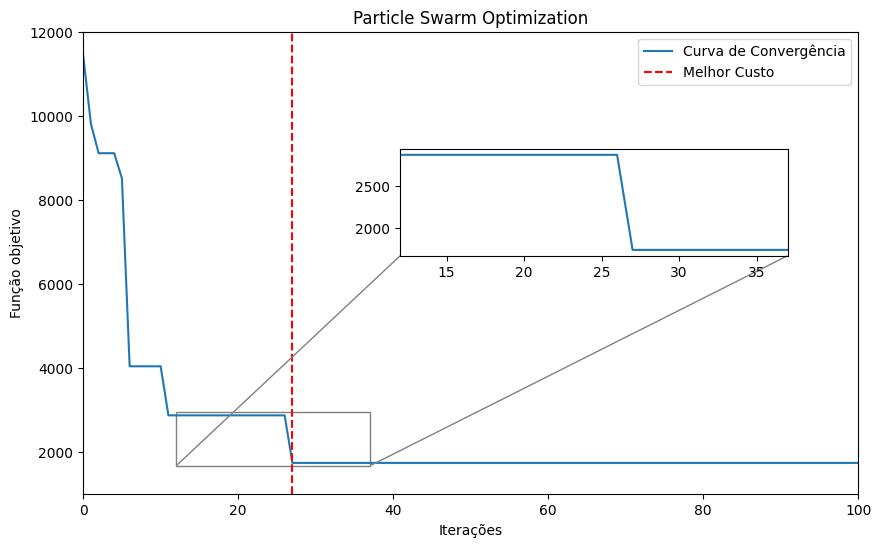


Cenário: primeiro_cenario
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: R$ 1.733,77
Número de Iterações até o Melhor Custo: 28
Tempo de Convergência para a segunda etapa: 1.1544947624206543 segundos


In [110]:
# Plotar gráfico de densidade da otimização

# Localizando o índice da melhor interação
index_melhor_custo = cost_history.index(min(cost_history))

# Criar a figura e o eixo principal
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cost_history, label='Curva de Convergência')

# Plotando a linha vertical no gráfico principal
ax.axvline(index_melhor_custo, color='red', linestyle='--', label='Melhor Custo')

# Labels e título
ax.set_xlabel('Iterações')
ax.set_xlim(0, len(cost_history) - 1)
ax.set_ylabel('Função objetivo')
plt.xlim(0, 100)
plt.ylim(1000, 12000)
ax.set_title('Particle Swarm Optimization')


# Adicionar a região de zoom
# Definindo a área de interesse para o zoom
x1, x2 = max(0, index_melhor_custo - 15), min(len(cost_history) - 1, index_melhor_custo + 10)
y1, y2 = min(cost_history[x1:x2]) - 70, max(cost_history[x1:x2]) + 70

# Criando o gráfico de zoom (posicionado para não sobrepor a linha de convergência)
axins = zoomed_inset_axes(ax, zoom=2, loc='lower left', bbox_to_anchor=([0.4, 0.5, 0.3, 0.4]), bbox_transform=ax.transAxes)
axins.plot(cost_history)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Remover ticks na área de zoom para limpar a visualização
# plt.xticks(visible=False)
# plt.yticks(visible=False)

# Conectar a região de zoom com o gráfico principal
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

ax.legend()
plt.show()

print("")
print('Cenário:', CENARIO)
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", melhorCusto)
print("Número de Iterações até o Melhor Custo:", numero_interacoes)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

In [78]:
gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2024-06-28 22:49:23,910 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:23,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80825661 1.10233009 0.23659251 1.09920022 0.22675202 0.59542894
 0.73473301 0.98072941 0.34331802 0.56970347 0.42904236 0.81697287
 0.58661299 0.5754818  1.05270269 0.51461505 0.60579067 0.52682143
 0.48046183 0.36356517 0.73518373 0.48259648 0.86576991 0.57175029]
2024-06-28 22:49:23,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 544]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 47.92522340093157, 60.859413356498735]
Custo =  4825.373479983277


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8082401  1.10297323 0.87542652 1.13461969 0.23193385 0.59548671
 0.73312246 0.9806989  0.34344768 0.56976587 0.42890883 0.8196891
 0.58691782 0.58481485 1.08849363 0.51462202 1.17990662 0.52887689
 1.29398628 0.36355217 0.73701511 0.48272581 0.86619828 0.57175203]
2024-06-28 22:49:24,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 91, 545]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.2350855106665545, 45.58695794095518, 58.30871954704325]
Custo =  5069.4785327592745


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80821355 1.10352943 0.14479364 1.01877856 0.23607399 0.59553548
 0.73088852 0.98058389 0.34340157 0.56968082 0.42879574 0.82165367
 0.58704897 0.64923655 1.09368335 0.51463024 0.37666541 0.53244407
 0.69198049 0.36352694 0.73830945 0.48306389 0.86646318 0.57175629]
2024-06-28 22:49:24,059 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 94, 330, 545]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.25889066490389684, 9.905630090219594, 41.3088567048886, 54.03061831097668]
Custo =  6390.363826000743


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80817911 1.10373233 0.84146329 0.78624034 0.23903577 0.59555609
 0.72824298 0.98033591 0.34324164 0.5694911  0.42873289 0.82257843
 0.58702637 0.7299333  1.08939676 0.51463774 0.92118615 0.53573287
 0.08196313 0.36349793 0.73905267 0.48346051 0.8662746  0.57176227]
2024-06-28 22:49:24,100 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 97, 330, 544]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.28424364681795045, 9.882072358108857, 41.057359405919456, 53.99154936148662]
Custo =  6385.802337694469


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80814767 1.10368421 0.16371914 0.45059932 0.23938945 0.59553234
 0.7246735  0.97999348 0.34305972 0.56926794 0.42875032 0.82165333
 0.58693408 0.88276388 1.07635211 0.51464469 0.11001323 0.53932411
 0.96302776 0.36347195 0.73886025 0.48385501 0.86587788 0.57176878]
2024-06-28 22:49:24,145 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 30, 98, 331, 420, 543]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.008671307320240214, 0.2663420920642437, 9.939188880514266, 19.095431005676986, 39.832975759288985, 52.978942514261696]
Custo =  8393.992853147729


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80811942 1.10320928 0.84150364 0.07833334 0.23695398 0.5954962
 0.72138287 0.97967959 0.34284404 0.56906712 0.42882537 0.81977149
 0.58671573 1.00418448 1.05374859 0.51464966 0.56317709 0.54228194
 0.45937876 0.36344978 0.73754875 0.48419736 0.86543305 0.57177463]
2024-06-28 22:49:24,180 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 32, 211, 398, 421, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 2.72527724695278, 16.449656276552012, 19.180078123891207, 39.34948146244431, 52.91705192875119]
Custo =  9306.463002438784


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 1, 34, 212, 391, 421, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 3.5107458165773186e-07, 0.012456864515253196, 2.756045181412296, 15.579127935737635, 19.0893706112998, 39.04339737031375, 52.82079713006447]
Custo =  11225.935245134415


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,217 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081048  1.10266215 0.14914753 1.16591227 0.23413005 0.59543492
 0.71915771 0.97945007 0.34265987 0.56892102 0.42894614 0.81748144
 0.58646058 1.15149362 1.01530837 0.51465199 1.03756748 0.54487603
 1.23937385 0.36343127 0.73564204 0.48448352 0.86498986 0.57177864]
2024-06-28 22:49:24,227 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80810688 1.10212884 0.86852945 0.84125263 0.22896253 0.59537798
 0.71843885 0.97928703 0.34253494 0.56889532 0.42906552 0.81526185
 0.58620612 0.03142789 0.97681509 0.51465396 0.12937715 0.54674673
 0.60296486 0.36



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 3, 35, 213, 421, 481]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 9.21021316427903e-06, 0.013323104919977803, 2.7911190625575553, 19.48064884638494, 28.195027198427006, 53.24832362183702]
Custo =  7580.673918771796


2024-06-28 22:49:24,251 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80812034 1.10165043 0.21525904 0.44287366 0.22346533 0.59532686
 0.7181704  0.97922586 0.34249741 0.56897951 0.42917176 0.81344914
 0.58598944 0.3272985  0.94451975 0.51465363 0.69114939 0.54656281
 1.27561217 0.36340807 0.73247199 0.48482718 0.86423851 0.57177943]
2024-06-28 22:49:24,275 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 4, 36, 212, 421, 481]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 2.1667777029020755e-05, 0.014365520608316331, 2.7473869320720294, 19.481517529527043, 28.195895881569108, 53.24919230497912]
Custo =  7410.893253247861


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 2, 37, 128, 212, 394, 420, 480]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 2.7580800851165424e-06, 0.01588533198418321, 0.5916202398969832, 2.4916241673092, 15.678813325715396, 18.73155040294225, 27.408221248072373, 52.63464966916459]
Custo =  9852.379748756215


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80813408 1.10125693 0.83387455 0.0054417  0.21868199 0.59529284
 0.7187683  0.97921776 0.34256815 0.56905916 0.42923832 0.8122258
 0.58587769 0.70287653 0.92480005 0.51465024 1.21182924 0.54552918
 0.50846915 0.36341929 0.73195311 0.48473295 0.86394662 0.57177884]
2024-06-28 22:49:24,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80814785 1.10093772 0.08563073 0.98114974 0.21466871 0.59527561
 0.72066588 0.97927583 0.34267738 0.56919543 0.42927266 0.81167154
 0.58587391 1.15713721 0.92478638 0.51464524 0.29894024 0.54287392
 1.1193276  0.363



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 36, 95, 211, 420]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.014912654199187601, 0.23884895585374225, 2.5040204196320874, 19.142166120800486, 53.74687697090367]
Custo =  4561.283589823876


2024-06-28 22:49:24,338 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 35, 210, 398, 420, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.013714246102670411, 2.6742150228593426, 16.440904991640245, 19.045472056089842, 39.13399862186158, 52.9113983816123]
Custo =  9283.702330614944



2024-06-28 22:49:24,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816165 1.10091571 0.59945084 0.56999545 0.21262029 0.59526907
 0.72263121 0.97944552 0.34281596 0.56932364 0.42923353 0.81233289
 0.58597882 0.18817372 0.9417247  0.51463895 0.72021052 0.53951858
 0.34600772 0.3634731  0.73272762 0.48433522 0.86387782 0.57177114]
2024-06-28 22:49:24,369 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80817421 1.10127473 1.08702702 0.12533257 0.21150492 0.59528104
 0.72452962 0.97969389 0.34294275 0.56943479 0.42915256 0.81338343
 0.58607849 0.63064859 0.96927873 0.5146333  1.12065063 0.53629231
 1.01422209 0.36350869 0.73342922 0.48394359 0.86403966 0.57176653]
2024-06-28 22:4



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 31, 394, 542]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 17.880558078166413, 41.72935892764168, 55.08645212261796]
Custo =  6732.647450128665


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,424 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80818435 1.10169321 0.20610712 0.9909625  0.21352745 0.59530124
 0.72620215 0.97998234 0.34304348 0.56952966 0.42907008 0.81472848
 0.58618747 1.12953366 0.99473753 0.51462877 0.16396701 0.53354781
 0.31959231 0.36353937 0.7344391  0.48356819 0.86423139 0.57176243]
2024-06-28 22:49:24,429 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,459 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80818856 1.10214398 0.71780301 0.47255804 0.21760116 0.59533551
 0.72762036 0.98022768 0.34310047 0.56957886 0.42898686 0.81617974
 0.58630579 0.24650204 1.01735253 0.51462723 0.55785891 0.53236133
 0.98766579 0.36



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 30, 96, 124, 542]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.008671307320240214, 0.25010266148695065, 0.5061525485807221, 43.921375234668126, 57.27846842964441]
Custo =  5416.4249048118345


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80818691 1.10256465 1.19270777 1.17862666 0.22324491 0.59537881
 0.72805138 0.98038139 0.34310003 0.56957322 0.42891874 0.81745478
 0.58640967 0.75081456 1.03562894 0.51462774 0.91685048 0.53293583
 0.29325485 0.36356444 0.73635517 0.48305386 0.86481349 0.5717577 ]




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 390, 542]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 17.81336280939398, 42.145295347953464, 55.50238854292975]
Custo =  6593.496404329077


2024-06-28 22:49:24,497 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 542]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 47.40314896256212, 60.76024215753841]
Custo =  4804.488715885807



2024-06-28 22:49:24,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80818269 1.10286665 0.27914645 0.47643785 0.22833416 0.59541784
 0.72751203 0.98045124 0.34304423 0.56954473 0.42886388 0.8182801
 0.5864887  0.02727907 1.04185145 0.51463131 1.22451514 0.53453744
 0.92942561 0.36355178 0.73699511 0.48297693 0.86509025 0.57175678]
2024-06-28 22:49:24,526 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 95, 127, 542]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.2671673026113657, 0.5668514846529824, 43.8675023518167, 57.22459554679298]
Custo =  5325.020358734919



2024-06-28 22:49:24,559 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80817793 1.10313686 0.69975149 1.06112373 0.23192082 0.5954472
 0.72608971 0.98045812 0.34297692 0.56948143 0.4288324  0.81854144
 0.58655898 0.6792794  1.03572756 0.51463625 0.13304534 0.53643668
 0.21764738 0.36353826 0.73708531 0.48304994 0.86529659 0.57175736]
2024-06-28 22:49:24,561 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 541]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 47.14353335264525, 60.71110381895213]
Custo =  4794.099481536746



2024-06-28 22:49:24,597 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816988 1.10318128 1.10689711 0.28423456 0.23484274 0.59545929
 0.72436012 0.98036994 0.34289639 0.56938714 0.42882869 0.81866287
 0.58656636 0.00396866 1.02233068 0.51464087 0.354193   0.5383634
 0.92069877 0.36351729 0.73691079 0.48327653 0.8654778  0.57175984]
2024-06-28 22:49:24,599 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 30, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.008671307320240214, 46.26710874329624, 59.834679209603124]
Custo =  4916.076609858148


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816123 1.10298919 0.16301917 0.88221971 0.23640052 0.59544914
 0.7227614  0.98027305 0.34282092 0.56928029 0.4288742  0.8183954
 0.58650711 0.70482961 1.00503966 0.51464448 0.67237789 0.54009661
 0.28048644 0.36349805 0.73647711 0.48351392 0.86555143 0.57176262]
2024-06-28 22:49:24,627 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80815455 1.10268564 0.585092   0.14555011 0.23743567 0.59542106
 0.72137935 0.9800904  0.34277052 0.56918322 0.42895836 0.81792378
 0.5864144  0.11431794 0.98595371 0.5146474  0.99935916 0.54155593
 1.03283999 0.363



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 31, 127, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 0.5854522554783955, 43.394785551681444, 57.172185311432166]
Custo =  5217.302543153692


2024-06-28 22:49:24,651 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80815071 1.10237329 0.98306395 0.73905597 0.23813758 0.59539041
 0.72083102 0.97989157 0.34274645 0.56911688 0.42905433 0.8174729
 0.58631925 0.8943526  0.96967965 0.51464975 1.28749527 0.54189712
 0.41006933 0.36346547 0.73549485 0.48393955 0.86529861 0.57176795]
2024-06-28 22:49:24,682 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 1, 32, 210, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 3.5107458165773186e-07, 0.010395395774668111, 2.6863134115640834, 41.69393927320431, 55.47133903295503]
Custo =  7563.103701875099


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,698 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80814897 1.10208795 0.03819067 0.0158793  0.23533078 0.59536178
 0.72051196 0.97971841 0.34275172 0.56907946 0.42913976 0.81674279
 0.58622927 0.23224142 0.95617167 0.51465072 0.12723639 0.54155101
 1.09062802 0.36345921 0.73501501 0.48408001 0.86506474 0.57177009]
2024-06-28 22:49:24,703 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 2, 34, 128, 210, 420]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 2.7580800851165424e-06, 0.012333622114484251, 0.5954067907724689, 2.425242094604677, 19.107398199697183, 53.71210904980036]
Custo =  5637.680582465751


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 2, 35, 210, 420]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 2.7580800851165424e-06, 0.013451618531532558, 2.6739523952882047, 19.35610850038071, 53.96081935048389]
Custo =  5402.154763489656


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80815034 1.10186566 0.40654834 0.63357244 0.23249243 0.59534023
 0.72095524 0.97961782 0.34277296 0.56909757 0.42920395 0.81608061
 0.58614978 0.93653165 0.94576699 0.51464941 0.31296355 0.54079895
 0.39440831 0.36346018 0.73458552 0.48416712 0.86478964 0.5717719 ]
2024-06-28 22:49:24,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1<ipython-input-71-f2a244820fa5>:79: RuntimeWarning: divide by zero encountered in scalar divide
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80815034 



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 0, 35, 121, 210]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.0, 0.013714246102670411, 0.5007281082263829, 2.4280639383567686, 57.29058542738369]
Custo =  inf


2024-06-28 22:49:24,751 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,772 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80815875 1.10174616 0.94499749 0.4573681  0.2250608  0.59531034
 0.72347603 0.97954253 0.34285575 0.56923165 0.42925868 0.81529554
 0.58607803 0.9015958  0.94576504 0.5146411  0.69781571 0.53902443
 0.20924995 0.36347888 0.73423279 0.4840502  0.8643669  0.57177133]
2024-06-28 22:49:24,774 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 35, 210, 396, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.013714246102670411, 2.6742150228593426, 16.191980997176636, 39.35983453274608, 53.1372342924968]
Custo =  7308.277230574847


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816251 1.10188425 1.10742445 0.93812079 0.22205713 0.59530131
 0.72501766 0.97959361 0.34288965 0.56929409 0.42921269 0.81526283
 0.58611333 0.27689001 0.95856574 0.51463691 0.82748935 0.53808767
 0.85368348 0.36348694 0.73432528 0.48388598 0.86424484 0.57176911]
2024-06-28 22:49:24,799 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 35, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.013714246102670411, 45.868267875728385, 59.64566763547911]
Custo =  4906.680504941805


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 34, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.012581551635142395, 46.15191185275589, 59.71948231906277]
Custo =  4916.668557979537


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,827 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081663  1.10201544 1.24454689 0.08504769 0.22008904 0.59531329
 0.72635511 0.97964248 0.34291894 0.56935012 0.42915786 0.81544419
 0.58619005 1.00472665 0.97338961 0.5146335  0.94770225 0.53724491
 0.17961875 0.36349637 0.73451    0.48368227 0.86416244 0.57176648]
2024-06-28 22:49:24,829 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 34, 396, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.012581551635142395, 18.10825421166523, 41.49394597637901, 55.06151644268589]
Custo =  6736.002989544747


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816951 1.10213477 1.2378165  0.6249308  0.21855147 0.59532595
 0.72750579 0.97976468 0.34293925 0.56938751 0.42907611 0.81575531
 0.58628343 0.39167073 0.98832747 0.51463087 1.04378257 0.53658746
 0.79764267 0.36350546 0.73469378 0.48348227 0.86419059 0.57176418]
2024-06-28 22:49:24,851 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,872 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80817125 1.10226177 1.14373297 1.159056   0.21741613 0.59533957
 0.7284695  0.97990561 0.34294888 0.56942109 0.42899869 0.81604043
 0.58636758 1.12475051 1.00218177 0.51463045 1.09651344 0.53614394
 0.11996287 0.36



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 90, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.2038839161633389, 44.584230144986435, 58.15180061129332]
Custo =  5115.330784875317


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:24,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80817179 1.10236995 0.95648741 0.30461826 0.21676268 0.59535582
 0.72847019 0.98003261 0.34295123 0.56942537 0.42893099 0.81629599
 0.58644171 0.40877366 1.01227221 0.51463128 1.08408691 0.53611347
 0.8540827  0.36351639 0.73517888 0.48321664 0.86461155 0.5717622 ]
2024-06-28 22:49:24,922 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 398, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 18.41518692718688, 41.55477069118529, 55.12234115749217]
Custo =  6751.675071448936


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 31, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 46.23826429800098, 59.80583476430786]
Custo =  4916.011655680144



2024-06-28 22:49:24,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081713  1.10245834 0.78688033 0.89989528 0.21784381 0.59537239
 0.72826974 0.98013188 0.3429428  0.56942905 0.42887399 0.81652457
 0.58648082 1.04579217 1.02024564 0.51463298 1.00143201 0.53638165
 0.21576349 0.36351698 0.73537125 0.48312951 0.8648069  0.57176196]
2024-06-28 22:49:25,119 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80817058 1.10247153 0.63560195 0.14592264 0.21969284 0.59538808
 0.72760745 0.98021259 0.34292776 0.56942727 0.4288416  0.8166954
 0.58647823 0.31240144 1.02457507 0.51463586 0.92150511 0.5367813
 0.95337668 0.36351554 0.73548211 0.48305354 0.86498605 0.57176185]
2024-06-28 22:49:



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 31, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 46.23826429800098, 59.80583476430786]
Custo =  4916.011655680144


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816953 1.10240791 0.54321488 0.8895117  0.22194706 0.59539995
 0.72657958 0.9802246  0.34290607 0.56940053 0.42885714 0.81676862
 0.58644503 0.94852357 1.01879649 0.51463914 0.8476056  0.53723722
 0.3356173  0.36351414 0.73554632 0.48299779 0.86509918 0.57176217]
2024-06-28 22:49:25,213 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 31, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 46.23826429800098, 59.80583476430786]
Custo =  4916.011655680144


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,266 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816852 1.10231083 0.52958688 0.26190128 0.2243016  0.59540777
 0.72510889 0.98019258 0.34288342 0.56937358 0.42891649 0.81663567
 0.58639221 0.19682041 1.01300397 0.51464205 0.77948133 0.53791131
 1.14377575 0.36351125 0.73546178 0.48300616 0.86512615 0.57176355]
2024-06-28 22:49:25,277 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 31, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.009559452252332042, 46.23826429800098, 59.80583476430786]
Custo =  4916.011655680144


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,324 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816712 1.10219759 0.56898871 0.97074982 0.22649081 0.59540679
 0.72373308 0.98014958 0.34286312 0.56933517 0.42899577 0.81640852
 0.58631933 0.83305624 1.004292   0.51464428 0.72059968 0.53851854
 0.54648626 0.36350771 0.73533425 0.4831085  0.86506106 0.5717657 ]
2024-06-28 22:49:25,332 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 46.2094496340501, 59.777020100356985]
Custo =  4916.096574568208


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,370 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816549 1.10209634 0.61350892 0.31498064 0.22838862 0.59539866
 0.72252898 0.98005134 0.34284813 0.5692932  0.42906814 0.81615336
 0.58625223 0.20111164 0.99364884 0.51464543 0.69041227 0.53902978
 1.22555568 0.36350375 0.73516762 0.48331549 0.86499631 0.57176774]




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 210, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 2.686424001701969, 41.69404986334219, 55.47144962309291]
Custo =  5560.977127281874


2024-06-28 22:49:25,395 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816402 1.10203867 0.6877694  0.95848856 0.22938192 0.59538842
 0.72172646 0.97995562 0.3428405  0.56925415 0.42913215 0.815902
 0.58619298 0.93966389 0.98395599 0.51464553 0.67825417 0.53942882
 0.53157772 0.36349893 0.73501394 0.48352766 0.86488938 0.57176955]
2024-06-28 22:49:25,442 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 33, 93, 210, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.22533453667900982, 2.473918580329398, 41.48154444196962, 55.25894420172034]
Custo =  5714.819711923121


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816298 1.10199252 0.76469001 0.25119357 0.22969461 0.59537786
 0.72126622 0.97985985 0.34283976 0.56922306 0.42917866 0.81569318
 0.58615082 0.35860148 0.97544653 0.51464389 0.68383599 0.53950921
 1.14072052 0.36349446 0.73487954 0.48372518 0.86478469 0.57177066]
2024-06-28 22:49:25,573 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 210, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 2.6823306477462716, 41.68995650938649, 55.46735626913721]
Custo =  5560.29684270048


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816239 1.1019543  0.84103628 0.85107193 0.22889616 0.59536844
 0.72131745 0.97978183 0.34283992 0.56920113 0.42920142 0.81555573
 0.58612337 1.12681616 0.9683717  0.51464169 0.71329716 0.53922109
 0.36558168 0.36349164 0.73478732 0.48389203 0.86469848 0.57177085]
2024-06-28 22:49:25,624 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 34, 210, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.012581551635142395, 2.6782608048647947, 41.68588666650501, 55.463286426255735]
Custo =  5559.744205172201


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081619  1.1019429  0.90772442 0.12509008 0.22738255 0.59536291
 0.72217858 0.97973507 0.34285212 0.56918368 0.42919416 0.81550532
 0.58613707 0.57663452 0.96387958 0.51463943 0.76956272 0.53871082
 1.00720641 0.36349082 0.73477283 0.48400035 0.8646209  0.57177075]
2024-06-28 22:49:25,676 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 34, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.012581551635142395, 45.89688317664399, 59.67428293639471]
Custo =  4906.216626308984


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,718 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816167 1.10194952 0.95039086 0.88978811 0.22530985 0.59536048
 0.72348976 0.97972902 0.34286489 0.56918925 0.42915031 0.8155843
 0.58617679 0.05672736 0.9655493  0.51463729 0.83936411 0.53811934
 0.29195651 0.36349027 0.73476973 0.48406339 0.86459085 0.57177015]
2024-06-28 22:49:25,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 34, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.012581551635142395, 45.89688317664399, 59.67428293639471]
Custo =  4906.216626308984


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,766 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816149 1.10197334 0.98675045 0.28293272 0.22324157 0.59536319
 0.72469443 0.97972679 0.34287661 0.56921162 0.42910756 0.81571832
 0.58621578 0.88978571 0.97169905 0.51463537 0.90250463 0.53758966
 0.85871734 0.36349197 0.73480699 0.48410726 0.86462018 0.57176961]
2024-06-28 22:49:25,769 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 34, 97, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.012581551635142395, 0.2556392058658722, 44.14954851417035, 57.92694827392107]
Custo =  5122.438812560416


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816143 1.10202926 1.01045027 1.00605414 0.221491   0.59536896
 0.72564942 0.97977414 0.34288762 0.56924087 0.42905565 0.81592348
 0.58625996 0.40723064 0.98085535 0.51463469 0.95823377 0.53720997
 0.07955758 0.36349461 0.73485203 0.48408651 0.86470204 0.57176837]




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 45.925529887794305, 59.70292964754503]
Custo =  4905.870045619421


2024-06-28 22:49:25,815 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816223 1.10213457 0.98055345 0.3586275  0.22058566 0.59537667
 0.7265026  0.97982    0.3428975  0.56927663 0.42900237 0.81610835
 0.58630072 1.26239733 0.99183185 0.51463459 1.00040069 0.53687791
 0.70016296 0.3634971  0.73493352 0.48406461 0.86479591 0.57176685]
2024-06-28 22:49:25,858 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 392, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 17.579558856698576, 41.45176492879894, 55.01933539510582]
Custo =  6705.396747536017


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:25,881 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816381 1.10223046 0.92880265 1.00928133 0.22024511 0.595384
 0.72696196 0.97987116 0.34290257 0.56930888 0.42895679 0.81626126
 0.58633653 0.68435724 1.00149396 0.51463562 1.03104266 0.53677926
 0.0518614  0.36349963 0.7350113  0.48397538 0.86488733 0.57176548]
2024-06-28 22:49:25,887 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 32, 120, 395, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.49149366987202936, 16.781351191691876, 40.28938244406568, 53.85695291037256]
Custo =  6980.136848419948



2024-06-28 22:49:25,935 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816554 1.10231481 0.87944595 0.29779437 0.21996932 0.59538957
 0.72728223 0.97992659 0.34290265 0.56933693 0.42892602 0.81634116
 0.58636301 0.12551037 1.00754504 0.51463666 1.05781389 0.53700435
 0.71201254 0.36350177 0.73508196 0.48385906 0.86496892 0.57176439]
2024-06-28 22:49:25,948 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816708 1.1023869  0.83069517 0.82915657 0.22061877 0.59539245
 0.72697531 0.97997463 0.34289981 0.56935335 0.42892083 0.81636757
 0.58637939 0.94738744 1.01139377 0.51463781 1.07944575 0.53729203
 0.05315815 0.36350329 0.73514315 0.48368396 0.86500613 0.57176366]
2024-06-28 22:4



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 94, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.2333664769507556, 44.478308215719146, 58.04587868202603]
Custo =  5126.085094654784


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816844 1.10243002 0.78616069 0.03939671 0.22201761 0.59539448
 0.72600598 0.98000411 0.34289572 0.56935133 0.42892574 0.81628671
 0.58638445 0.50964838 1.01331939 0.51463886 1.07791706 0.53760735
 0.70778575 0.36350357 0.73516987 0.48351148 0.8650019  0.57176319]




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 32, 123, 397, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.5298948562717245, 17.007742748264356, 40.270619083696, 53.83818955000288]
Custo =  7004.773288753695


2024-06-28 22:49:26,069 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,136 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816905 1.10245738 0.75025095 0.51967603 0.22352218 0.59539623
 0.72464295 0.98002537 0.34288955 0.56933711 0.42895717 0.81619563
 0.58637557 0.10716281 1.01080573 0.51463982 1.00738065 0.53804408
 0.08597528 0.36350312 0.73518549 0.4833665  0.864975   0.5717638 ]
2024-06-28 22:49:26,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 95, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.2410255199518547, 44.451849054316696, 58.01941952062358]
Custo =  5128.732353360999


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,182 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816916 1.10246692 0.72895871 0.98928499 0.22513936 0.59539738
 0.72327544 0.98001301 0.34288352 0.56931549 0.4289871  0.81608342
 0.58634808 1.06855976 1.00363701 0.51464052 0.91553059 0.5384477
 0.90879818 0.36350138 0.73517455 0.4832704  0.86493608 0.57176509]
2024-06-28 22:49:26,190 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 32, 123, 398, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.5298948562717245, 17.139144190323385, 40.061087165061366, 53.83848692481209]
Custo =  7001.347819478096


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816879 1.10242792 0.71251726 0.12111078 0.22656413 0.59539469
 0.72218727 0.97998974 0.34287842 0.56929141 0.4290164  0.81596871
 0.58630977 0.65580097 0.99540188 0.51464076 0.81557657 0.53879315
 0.37412799 0.36349924 0.7351594  0.4831919  0.86487221 0.57176645]
2024-06-28 22:49:26,234 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 90, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.20436737416835948, 44.33562709837071, 58.11302685812143]
Custo =  5105.213713967629


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 32, 126, 392, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.5702491881812036, 16.32775833679639, 39.981731035000614, 53.759130794751336]
Custo =  6962.681024942463



2024-06-28 22:49:26,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816781 1.10235012 0.72302793 0.76354957 0.2274965  0.59539172
 0.72168059 0.97995993 0.3428757  0.5692682  0.42904381 0.81586553
 0.5862719  0.23531211 0.9866459  0.51464077 0.73005461 0.53892587
 1.07746759 0.36349723 0.73512746 0.48317842 0.86481193 0.5717678 ]
2024-06-28 22:49:26,297 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816655 1.10226443 0.7433246  0.09221443 0.22771214 0.59538858
 0.7214038  0.97992784 0.34287462 0.56924811 0.42906568 0.81580548
 0.5862425  1.15741897 0.97913862 0.51464073 0.67437556 0.53902892
 0.40683391 0.36349557 0.73507056 0.4832228  0.86475927 0.57176889]
2024-06-28 22:4



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 45.925529887794305, 59.70292964754503]
Custo =  4905.870045619421


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 125, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.5553400897560412, 43.44078237563059, 57.21818213538131]
Custo =  5208.824535438965


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816505 1.10217352 0.76170677 0.73021162 0.22762434 0.59538454
 0.72185685 0.97989741 0.34287406 0.56923505 0.42908492 0.81579299
 0.58622031 0.81253643 0.97347325 0.51464054 0.63443357 0.53893782
 0.97802186 0.36349457 0.7350128  0.48329294 0.86472695 0.57176985]
2024-06-28 22:49:26,498 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,552 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816372 1.10210205 0.78194042 0.02084803 0.22713614 0.59538017
 0.72239522 0.97987354 0.3428748  0.56922674 0.42910144 0.81580521
 0.5862182  0.43589158 0.97254028 0.51464037 0.6134568  0.53875164
 0.20145279 0.36



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 45.925529887794305, 59.70292964754503]
Custo =  4905.870045619421


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816268 1.10206031 0.80288064 0.66559828 0.22634779 0.59537621
 0.72306087 0.97986482 0.34287634 0.56922322 0.42910293 0.81584901
 0.58621887 0.04597996 0.97551357 0.51463997 0.63587583 0.53854512
 0.72911348 0.36349446 0.73493074 0.48352853 0.86469864 0.57177034]
2024-06-28 22:49:26,602 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 92, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.21802320497487593, 44.530878360327506, 58.09844882663439]
Custo =  5120.35997637529


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816246 1.10205728 0.82148815 0.02981897 0.22563615 0.59537378
 0.72386709 0.97986706 0.34287935 0.56922265 0.42910209 0.81589723
 0.58622588 1.01445706 0.98239498 0.51463937 0.71183579 0.53827365
 1.21444573 0.3634946  0.73490747 0.48367894 0.86472135 0.57176978]
2024-06-28 22:49:26,674 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,713 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816288 1.10206268 0.83413504 0.71636059 0.22477859 0.59537203
 0.7246658  0.97987199 0.34288217 0.56922738 0.42909357 0.81595305
 0.58625172 0.56868893 0.99097969 0.51463871 0.81878648 0.53801404
 0.30742497 0.36349495 0.73488657 0.48380317 0.86475214 0.57176881]
2024-06-28 22:49:26,715 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 391, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 17.445274515838495, 41.43792831598748, 55.00549878229436]
Custo =  6697.76993638655


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816377 1.10208991 0.84122105 0.08117824 0.22400215 0.59537207
 0.72528936 0.97987833 0.34288503 0.56924134 0.4290824  0.81601408
 0.58627825 0.11104624 0.99867305 0.51463813 0.91616385 0.53778712
 0.73521263 0.36349546 0.7348734  0.48387577 0.86478903 0.57176786]
2024-06-28 22:49:26,753 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 33, 95, 127, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.2404494965202646, 0.5401336785618813, 43.59466532517999, 57.16223579148687]
Custo =  5404.520418115118


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,785 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081647  1.10213293 0.84335783 0.8245991  0.22332877 0.59537349
 0.72578668 0.97988753 0.34288752 0.56926202 0.42906842 0.81606863
 0.5863041  1.0172455  1.00445479 0.5146376  0.98901676 0.53766674
 1.12236266 0.36349656 0.73486428 0.48389758 0.86482513 0.57176685]
2024-06-28 22:49:26,794 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 396, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 18.123557701001463, 41.50924946571524, 55.076819932022126]
Custo =  6736.06360016635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,820 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816562 1.10217962 0.84260617 0.21919819 0.22276765 0.59537569
 0.72619732 0.97989975 0.34288909 0.56928348 0.4290452  0.81610604
 0.58632605 0.45498172 1.00856231 0.51463748 1.0520407  0.53766459
 0.14910441 0.3634977  0.73485969 0.48390682 0.8648574  0.57176593]
2024-06-28 22:49:26,824 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 124, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.541914218039296, 43.71070297085861, 57.278273437165495]
Custo =  5216.156879679152


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,857 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816644 1.10222182 0.8363094  1.00994698 0.22269421 0.59537821
 0.72606585 0.97991491 0.34288961 0.5693012  0.42902184 0.81613468
 0.58634026 1.22189175 1.00960191 0.51463776 1.095971   0.53772635
 0.63510192 0.36349876 0.73486288 0.48389407 0.86488222 0.57176526]
2024-06-28 22:49:26,860 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 33, 92, 390, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.21802320497487593, 16.477348680320343, 40.58998027073298, 54.15755073703986]
Custo =  6869.194111900923


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,897 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816704 1.10225915 0.82275078 0.42556586 0.22296813 0.59538097
 0.72577357 0.97992865 0.34288885 0.56931457 0.42900175 0.81615565
 0.58635074 0.6578599  1.00997734 0.51463821 1.06713362 0.53786937
 1.09270635 0.36349966 0.73491189 0.48386392 0.86490266 0.57176474]
2024-06-28 22:49:26,899 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 46.2094496340501, 59.777020100356985]
Custo =  4916.096574568208


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:26,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816725 1.10228641 0.80475348 1.0741803  0.22354746 0.5953832
 0.72511872 0.97993906 0.3428876  0.56931705 0.42898697 0.81614515
 0.58635245 0.14414726 1.01020779 0.51463877 1.00944374 0.53803514
 0.20205876 0.36350029 0.73497287 0.48380107 0.86489838 0.5717648 ]
2024-06-28 22:49:26,938 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 45.95420745931408, 59.7316072190648]
Custo =  4905.65032050812


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 32, 91, 397, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.21137515809663815, 17.408908666824292, 40.454045504094665, 54.23144526384539]
Custo =  6910.935048891388



2024-06-28 22:49:27,013 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816716 1.10229875 0.78728115 0.35337967 0.22417175 0.59538473
 0.72445831 0.97994791 0.34288635 0.56931835 0.42897919 0.81611669
 0.58634667 0.98639943 1.00608073 0.51463931 0.93934666 0.53820468
 0.7611237  0.36350055 0.73504128 0.48371309 0.86488406 0.57176499]
2024-06-28 22:49:27,029 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,073 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081665  1.10228648 0.77410444 0.93329116 0.22482455 0.59538541
 0.72383117 0.97995129 0.3428848  0.56930768 0.42897649 0.8160883
 0.5863268  0.49459858 0.99961996 0.51463968 0.85604649 0.53835203
 0.02798318 0.3635005  0.73510062 0.48361407 0.86486136 0.57176539]
2024-06-28 22:49



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 126, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.5702491881812036, 43.41771089484628, 57.195110654597]
Custo =  5212.980456287117


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,116 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816557 1.10226565 0.76662588 0.16174763 0.22541193 0.59538503
 0.72328698 0.97995344 0.34288338 0.56929492 0.42897594 0.81604863
 0.58630622 0.03303101 0.99336114 0.51463995 0.77844887 0.53845141
 0.57853048 0.36350045 0.73515286 0.4835252  0.86483449 0.57176616]
2024-06-28 22:49:27,123 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 45.95420745931408, 59.7316072190648]
Custo =  4905.65032050812


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816462 1.10223442 0.76740346 0.73465605 0.22580675 0.59538453
 0.72302005 0.97994885 0.3428823  0.56927902 0.42897923 0.81600387
 0.58628722 0.94068706 0.98733754 0.51463998 0.72465003 0.53849107
 1.20225604 0.36350026 0.73518558 0.48345165 0.86481    0.5717669 ]
2024-06-28 22:49:27,170 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 45.95420745931408, 59.7316072190648]
Custo =  4905.65032050812


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816385 1.10220363 0.76866575 0.03067029 0.22580021 0.59538279
 0.72303909 0.97993904 0.34288177 0.56926466 0.42899105 0.81596535
 0.5862715  0.45657266 0.98238078 0.51464    0.70562203 0.53848305
 0.41531576 0.36349982 0.73518038 0.48342172 0.86479093 0.57176756]
2024-06-28 22:49:27,231 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 128, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.5969469157360467, 43.36800273331936, 57.14540249307008]
Custo =  5219.065007789276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,299 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816321 1.10217923 0.77204552 0.73764469 0.22569616 0.59538079
 0.72331559 0.97992681 0.34288162 0.56925277 0.42900525 0.8159312
 0.58625762 0.01503783 0.9786944  0.51463974 0.69515803 0.53845269
 0.95021153 0.36349938 0.73516917 0.48344041 0.8647785  0.57176796]




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 45.925529887794305, 59.70292964754503]
Custo =  4905.870045619421


2024-06-28 22:49:27,310 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,375 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816276 1.10216869 0.77736871 0.10265848 0.22546549 0.59537887
 0.72357788 0.97991553 0.3428823  0.56924867 0.42902279 0.81592025
 0.58624567 0.93154099 0.9774292  0.51463936 0.72486021 0.53840515
 0.1472598  0.36349894 0.73515864 0.48346746 0.86477979 0.57176803]
2024-06-28 22:49:27,380 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 90, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.2038839161633389, 44.584230144986435, 58.15180061129332]
Custo =  5115.330784875317


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,471 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816298 1.10216494 0.78860356 0.81901434 0.22514539 0.5953773
 0.7238655  0.9799056  0.34288363 0.56925143 0.42903965 0.81593739
 0.58624447 0.55816513 0.97684258 0.51463896 0.76047532 0.53835243
 0.67715927 0.36349846 0.73512669 0.48349931 0.86478762 0.57176773]




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 125, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.5553400897560412, 43.686190124939095, 57.25376059124598]
Custo =  5219.5329967319485


2024-06-28 22:49:27,490 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816322 1.1021717  0.80143127 0.19854091 0.22470092 0.5953763
 0.72419268 0.97989837 0.342885   0.56925649 0.42905147 0.81597462
 0.58625719 0.14196469 0.97681631 0.51463861 0.80504611 0.53830465
 1.17445667 0.36349803 0.73508876 0.48354789 0.86479756 0.57176743]
2024-06-28 22:49:27,561 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 96, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.24825669182493804, 44.42485269577291, 57.992423162079795]
Custo =  5130.82651469612


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081638  1.10218308 0.8126826  0.94830941 0.22429079 0.59537583
 0.72448466 0.97989503 0.34288622 0.56926421 0.42906162 0.81600945
 0.58627214 1.07630529 0.97863705 0.51463837 0.8506393  0.53825307
 0.3034503  0.36349766 0.73504742 0.48360372 0.86481296 0.57176702]
2024-06-28 22:49:27,649 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816465 1.10219916 0.82135123 0.34521009 0.22395392 0.59537622
 0.72474722 0.97989733 0.34288701 0.56927419 0.42906113 0.81604145
 0.58629102 0.721653   0.98228176 0.51463824 0.89048264 0.53817684
 0.69935771 0.36349754 0.73500701 0.48365713 0.86482918 0.57176665]
2024-06-28 22:49:27,728 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 33, 95, 125, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.2404494965202646, 0.5156648333127563, 43.64651486849581, 57.21408533480269]
Custo =  5401.046688026659


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816545 1.10221837 0.8252473  1.09053596 0.22379328 0.59537694
 0.72481967 0.97990199 0.34288716 0.5692838  0.42906061 0.81606813
 0.58630847 0.32548586 0.98775221 0.51463819 0.92534291 0.53810207
 1.15310331 0.36349753 0.73497433 0.48370463 0.86484343 0.57176634]
2024-06-28 22:49:27,779 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816608 1.10223557 0.8279658  0.45264062 0.22373763 0.59537788
 0.72475085 0.97990906 0.3428872  0.56929051 0.42905089 0.81608816
 0.58632043 1.26058305 0.99330962 0.51463835 0.94107497 0.53804369
 0.24719437 0.36349762 0.73495809 0.48374292 0.86485085 0.57176619]
2024-06-28 22:49:27,828 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081665  1.10225015 0.82817143 1.16783984 0.2238736  0.59537897
 0.72459598 0.97991699 0.34288674 0.56929286 0.42903771 0.81608572
 0.58633118 0.76260184 0.99768705 0.51463864 0.93100014 0.53802165
 0.67673097 0.36349773 0.7349592  0.48376432 0.86485288 0.57176609]
2024-06-28 22:49:27,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:27,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816656 1.10226085 0.82177302 0.5081615  0.22403787 0.5953801
 0.72434821 0.97992421 0.34288578 0.56929434 0.42902453 0.81606636
 0.58633703 0.19446674 1.0008224  0.51463894 0.91978227 0.53803909
 1.07863598 0.36349783 0.73496635 0.4837517  0.86485328 0.57176621]
2024-06-28 22:49:27,984 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 392, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 17.594576922352037, 41.24854962055626, 55.02594938030698]
Custo =  6694.208743379206


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816634 1.10226407 0.81049417 1.12206098 0.22432859 0.59538111
 0.72411477 0.97992918 0.34288474 0.56929068 0.42901303 0.8160467
 0.58633517 0.9936901  1.00249908 0.51463921 0.89027068 0.53806404
 0.13316506 0.36349799 0.73497956 0.48372385 0.8648515  0.57176645]




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 45.95420745931408, 59.7316072190648]
Custo =  4905.65032050812


2024-06-28 22:49:28,030 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816615 1.10225949 0.79879814 0.35726746 0.22461913 0.59538201
 0.7239113  0.97993044 0.3428838  0.56928588 0.4290057  0.81602602
 0.58632979 0.35549765 1.00366396 0.5146394  0.85866939 0.53809257
 0.50056213 0.36349818 0.73500042 0.48367785 0.86484219 0.57176673]
2024-06-28 22:49:28,075 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 45.95420745931408, 59.7316072190648]
Custo =  4905.65032050812


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,110 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081657  1.10224373 0.78838888 0.93037376 0.22487458 0.59538276
 0.72378389 0.97993021 0.34288311 0.56927979 0.42900064 0.81600641
 0.58632339 1.06347577 1.00201991 0.51463956 0.82917356 0.5381296
 0.85056713 0.36349841 0.73502701 0.48363482 0.86483213 0.57176699]
2024-06-28 22:49:28,116 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 45.95420745931408, 59.7316072190648]
Custo =  4905.65032050812


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816528 1.10222896 0.78187704 0.15624587 0.22503695 0.5953828
 0.72369811 0.9799275  0.34288274 0.56927382 0.42899811 0.81599006
 0.58630979 0.45725509 0.99827528 0.51463962 0.80455439 0.53816344
 1.20861491 0.36349862 0.73505204 0.48359487 0.86482176 0.5717672 ]
2024-06-28 22:49:28,169 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 32, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 45.95420745931408, 59.7316072190648]
Custo =  4905.65032050812


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816489 1.10221402 0.78009045 0.72567779 0.2251105  0.59538201
 0.72365589 0.97992495 0.34288272 0.5692685  0.42900282 0.81597651
 0.58629439 1.18921818 0.99386907 0.51463958 0.78605847 0.53819005
 0.21861684 0.36349881 0.73507147 0.48356307 0.86481248 0.57176728]
2024-06-28 22:49:28,209 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 392, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 17.579558856698576, 41.2335315549028, 55.01093131465352]
Custo =  6694.009964268866


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816456 1.10220058 0.78181864 1.26873144 0.22514382 0.59538082
 0.72374877 0.97992147 0.34288271 0.56926584 0.42901386 0.81597509
 0.58628053 0.57728656 0.98914556 0.51463949 0.7776869  0.53821071
 0.66698669 0.36349896 0.7350787  0.48354662 0.86480709 0.57176724]
2024-06-28 22:49:28,255 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 45.925529887794305, 59.70292964754503]
Custo =  4905.870045619421


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 124, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.541914218039296, 43.46519048903252, 57.242590248783245]
Custo =  5205.4512159794285


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.8081644  1.10218952 0.78525188 0.42079057 0.22510615 0.59537961
 0.72393111 0.97991769 0.34288318 0.56926658 0.42902714 0.81597476
 0.58627195 0.02287258 0.98524476 0.51463929 0.78821936 0.53821544
 1.09761324 0.36349904 0.73508417 0.48353881 0.86480637 0.57176717]
2024-06-28 22:49:28,300 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816426 1.10218606 0.78849695 1.00985554 0.22493164 0.5953786
 0.7241506  0.97991422 0.34288382 0.56926883 0.42903912 0.81597743
 0.58627088 0.87013246 0.98295417 0.51463906 0.80865898 0.53821504
 0.18188961 0.363



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816421 1.10218303 0.79395799 0.24722001 0.2247201  0.59537809
 0.72434707 0.97991131 0.34288458 0.56927313 0.42904714 0.81598937
 0.58627482 0.39708545 0.98201755 0.51463883 0.83157164 0.53820465
 0.59543397 0.36349908 0.73508446 0.48356629 0.86481292 0.57176694]




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 126, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.568986316904631, 43.661751062407824, 57.229321528714706]
Custo =  5222.929308357124


2024-06-28 22:49:28,378 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816423 1.10218861 0.80066282 0.95876035 0.22452205 0.59537819
 0.72447883 0.97990985 0.34288528 0.56927798 0.42905014 0.81600427
 0.58628134 1.26626971 0.98332291 0.51463864 0.85231033 0.53819026
 1.08673237 0.36349907 0.73507107 0.48359565 0.86481622 0.57176683]
2024-06-28 22:49:28,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 33, 92, 394, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.21802320497487593, 16.99763508320062, 40.627531082220514, 54.1951015485274]
Custo =  6900.38698450966


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816435 1.10219861 0.80666112 0.30196986 0.22435354 0.59537832
 0.72452107 0.97990889 0.34288579 0.56928223 0.42904693 0.81602019
 0.58629038 0.59166741 0.98610101 0.51463853 0.87011788 0.5381727
 0.21580023 0.36349892 0.73505083 0.48362478 0.8648193  0.57176674]




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


2024-06-28 22:49:28,493 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,520 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816465 1.10221268 0.81114412 0.95801084 0.22425148 0.59537863
 0.72445224 0.97991037 0.34288594 0.56928518 0.42904137 0.81603345
 0.58629917 1.19696689 0.9888774  0.51463843 0.8851816  0.53814974
 0.71042095 0.36349866 0.7350303  0.48364973 0.86482211 0.57176666]
2024-06-28 22:49:28,549 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 92, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.21802320497487593, 44.530878360327506, 58.09844882663439]
Custo =  5120.35997637529


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,584 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.808165   1.10222642 0.81344082 0.26602656 0.22421524 0.59537895
 0.72431141 0.97991303 0.34288605 0.56928694 0.4290346  0.81604341
 0.58630677 0.44128994 0.99172868 0.51463837 0.89140096 0.53812872
 1.15856307 0.36349838 0.73501201 0.4836659  0.86482481 0.57176662]
2024-06-28 22:49:28,589 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 541]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 46.18066530220036, 59.74823576850724]
Custo =  4916.319138684185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816531 1.10223689 0.81345103 0.87817826 0.22427929 0.59537937
 0.72416222 0.97991657 0.34288597 0.56928728 0.42902835 0.81604858
 0.5863114  1.01690872 0.99418589 0.51463846 0.88228249 0.53811233
 0.25330284 0.36349816 0.73500057 0.483672   0.86482663 0.57176664]
2024-06-28 22:49:28,624 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 120, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.49037887895483717, 43.80948153421349, 57.37705200052037]
Custo =  5202.857940323942


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,672 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816557 1.10224222 0.81011908 0.16232422 0.22436867 0.59537984
 0.72402713 0.97991992 0.34288557 0.56928698 0.42902268 0.81604914
 0.58631552 0.22961777 0.996188   0.51463861 0.87016324 0.5381018
 0.66359195 0.36349805 0.73499592 0.48367436 0.86482771 0.57176665]
2024-06-28 22:49:28,676 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 393, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 17.71452762903778, 41.465814834377454, 55.03338530068434]
Custo =  6713.039496024916


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 125, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 0.5565777774111667, 43.687427812594215, 57.2549982789011]
Custo =  5220.293391516314


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,707 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816578 1.10224488 0.80572138 0.92232649 0.22445946 0.59538032
 0.72393731 0.97992233 0.34288506 0.56928667 0.42901858 0.81604519
 0.58631294 0.82244271 0.99660441 0.51463882 0.85743928 0.53809728
 1.04659053 0.36349796 0.7350005  0.48366665 0.86482761 0.57176672]
2024-06-28 22:49:28,709 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 32, 397, 541]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.010505985912553516, 18.276691291698974, 41.539567627130616, 55.1071380934375]
Custo =  6743.955083361029



2024-06-28 22:49:28,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816594 1.10224718 0.80019422 0.30681521 0.22454924 0.59538072
 0.72390262 0.97992383 0.34288455 0.56928389 0.42901614 0.81603329
 0.58630577 0.15542167 0.99595532 0.51463901 0.84382383 0.53809638
 0.08816655 0.36349794 0.73501062 0.48365268 0.86482661 0.5717668 ]
2024-06-28 22:49:28,740 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,766 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816602 1.10224868 0.79522961 1.03145182 0.22463089 0.59538107
 0.7239428  0.97992427 0.34288412 0.56928024 0.4290145  0.81601885
 0.58629689 0.86842154 0.99515014 0.51463917 0.83094013 0.53810244
 0.44988413 0.36349802 0.73502131 0.48363023 0.86482549 0.57176688]
2024-06-28 22:4



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 124, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 0.541914218039296, 43.46519048903252, 57.242590248783245]
Custo =  5205.4512159794285


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 33, 394, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 17.85018254952094, 41.26204279118424, 55.039442550934965]
Custo =  6709.3082687448605



2024-06-28 22:49:28,845 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816607 1.10224953 0.79159852 0.38521992 0.22470327 0.59538115
 0.72402312 0.97992312 0.34288385 0.56927635 0.42901507 0.81600584
 0.58628857 0.19034107 0.99324556 0.51463932 0.82220189 0.53811317
 0.90969065 0.36349814 0.7350323  0.48360824 0.86482409 0.57176694]
2024-06-28 22:49:28,847 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.73e+3
2024-06-28 22:49:28,943 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1733.7672493343252, best pos: [0.80816606 1.10224592 0.78956621 0.99604412 0.22474625 0.59538111
 0.72413156 0.97992103 0.34288363 0.56927294 0.42901755 0.81599612
 0.5862815  0.88620249 0.99085346 0.51463941 0.81977204 0.53813112
 0.0492571  0.36349828 0.73504212 0.4835903  0.8648228  0.57176699]




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 33, 540]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638]
Media de falhas:  [0, 0.011512741730381693, 45.925529887794305, 59.70292964754503]
Custo =  4905.870045619421


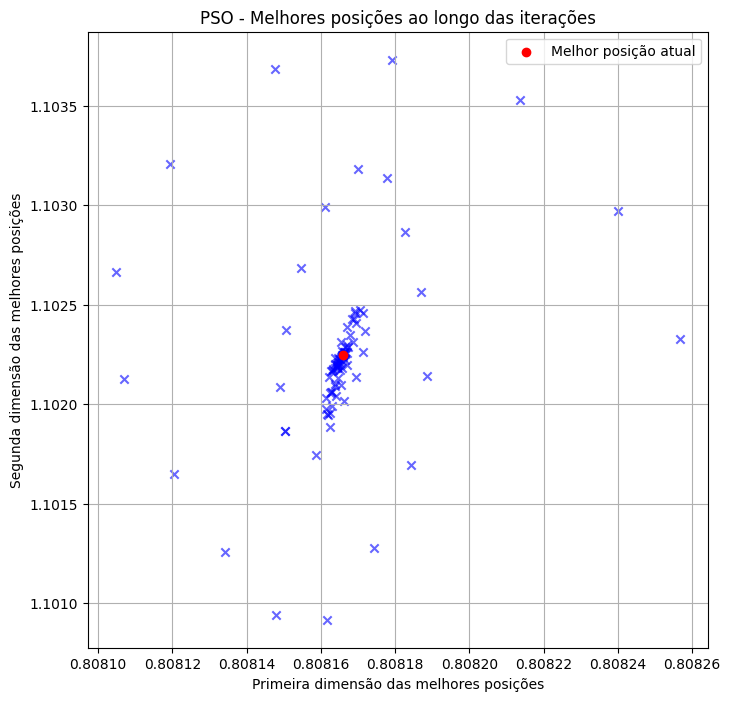

In [79]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [80]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [81]:
print(nome_arquivo)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_primeiro_cenario/melhor_custo_pso_primeiro_cenario.csv


In [82]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(melhorCusto)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), melhorCusto, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [83]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 1.788,02",1.182193,NaN
1,2,"R$ 1.748,33",1.205202,NaN
2,3,"R$ 1.958,49",1.353549,NaN
3,4,"R$ 2.673,05",1.308372,NaN
4,5,"R$ 1.798,96",1.326305,NaN
5,6,"R$ 1.790,14",1.387868,NaN
6,7,"R$ 2.203,51",1.512366,NaN
7,8,"R$ 1.748,33",1.373484,NaN
8,9,"R$ 2.093,13",1.091680,NaN
9,10,"R$ 1.748,95",1.381453,NaN


In [84]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       10 non-null     int64  
 1   Melhor_Custo                10 non-null     object 
 2   Convergencia_Segunda_Etapa  10 non-null     float64
 3   Ciclos_MP                   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 448.0+ bytes


In [85]:
resultado.describe()

,Index,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,10.000000,0.0
mean,5.50000,1.312247,NaN
std,3.02765,0.121677,NaN
min,1.00000,1.091680,NaN
25%,3.25000,1.230994,NaN
50%,5.50000,1.339927,NaN
75%,7.75000,1.379461,NaN
max,10.00000,1.512366,NaN


In [86]:
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

In [87]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [88]:
# # Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(convergencia):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [89]:
# Arrays de tempos e severidade
Tempos = [
[[303]],
[[336]],
[[272]],
[[62]],
[[517]],
[[364]],
[[332]],
[[360]],
[[395]],
[[303]],
]

severidade = [
    [[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
]

# # Verifica se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
#         file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [90]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,[303],[0.5]
1,[336],[0.5]
2,[272],[0.5]
3,[62],[0.5]
4,[517],[0.5]
5,[364],[0.5]
6,[332],[0.5]
7,[360],[0.5]
8,[395],[0.5]
9,[303],[0.5]


In [91]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [92]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,9,1
top,[303],[0.5]
freq,2,10


In [107]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}_comparacao.csv', sep=";")
dados.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,numero_interacoes
0,1,1733.77,1.154495,28
1,2,1734.12,1.371881,63
2,3,1737.25,0.926272,35
3,4,1735.03,0.972174,42
4,5,1785.87,1.316223,42
5,6,1737.25,1.252728,18
6,7,1734.12,1.276472,7
7,8,1871.46,1.254198,53
8,9,1733.77,1.317160,58
9,10,1776.88,1.237171,37


In [108]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       10 non-null     int64  
 1   Melhor_Custo                10 non-null     float64
 2   Convergencia_Segunda_Etapa  10 non-null     float64
 3   numero_interacoes           10 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 448.0 bytes


In [109]:
dados.describe()

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,numero_interacoes
count,10.00000,10.000000,10.000000,10.00000
mean,5.50000,1757.952000,1.207877,38.30000
std,3.02765,44.359366,0.148326,17.48682
min,1.00000,1733.770000,0.926272,7.00000
25%,3.25000,1734.120000,1.175164,29.75000
50%,5.50000,1736.140000,1.253463,39.50000
75%,7.75000,1766.972500,1.306285,50.25000
max,10.00000,1871.460000,1.371881,63.00000
